# Cross Correlations with CIB -- Example: BOSS CMASS x Planck

In [2]:
# Initialization
import numpy as np
import matplotlib.pyplot as pl
from scipy import interpolate
from scipy import stats
import healpy as hp  # NOTE: you can neglect warning about version mismatch in CFITSIO if necessary 

N_side = 2048      # Both maps will have this N_side. Healpix map has 12 * N_side**2 pixels

## Loading and plotting maps

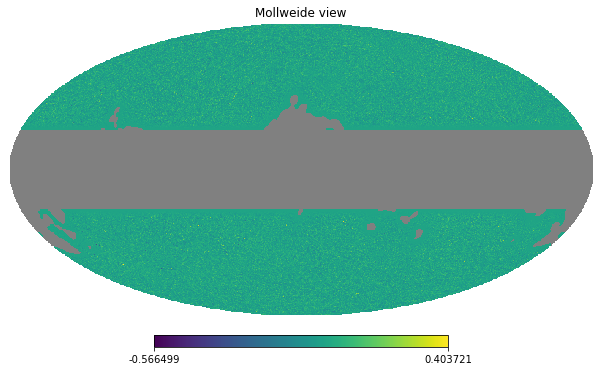

In [3]:
# Planck 2018 CIB map: http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits
CIB_map = hp.read_map('COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits')        # read CIB map
CIB_mask = hp.read_map('/Users/sophiarisin/Dropbox/Mac (2)/Downloads/cib_mask.fits')                                    # read CIB mask

CIB_masked = hp.ma(CIB_map)
CIB_masked.mask = np.logical_not(CIB_mask)
hp.mollview(CIB_masked)

In [7]:
# CMASS map, total number counts. Should convert to delta_n/n. Make a mask first!
CMASS_map = hp.fitsfunc.read_map('galaxy_DR12v5_CMASS_North.fits') # this is a cataloge lol 
CMASS_downgraded = hp.ud_grade(CMASS_map, 64)
CMASS_mask = np.zeros(len(CMASS_downgraded))
CMASS_mask[(CMASS_downgraded > 0)] = 1
CMASS_mask = hp.ud_grade(CMASS_mask, N_side) # bring it back to the original resolution
hp.mollview(CMASS_mask)
coord= ['G','C']

ValueError: Wrong pixel number (it is not 12*nside**2)

In [7]:
# Convert to delta_n / n (fractional fluctuations: this is what we can predict from theory)
mean_CMASS = np.sum(CMASS_map * CMASS_mask) / np.sum(CMASS_mask)
CMASS_masked_dn = (CMASS_map * CMASS_mask) / mean_CMASS - 1.
CMASS_masked_dn = CMASS_mask * CMASS_masked_dn

NameError: name 'CMASS_map' is not defined

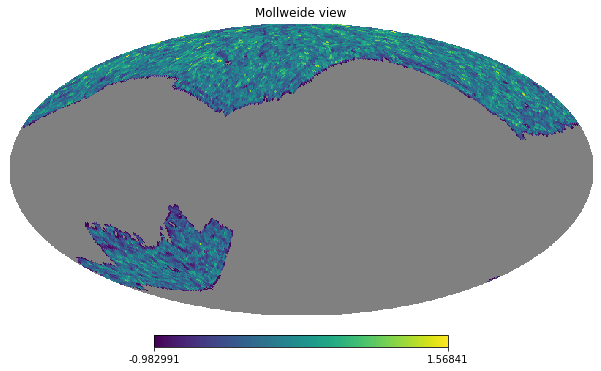

In [8]:
# Convert to a masked array for better plotting
CMASS_masked_dn = hp.ma(CMASS_masked_dn)
CMASS_masked_dn.mask = np.logical_not(CMASS_mask)
hp.mollview(hp.ud_grade(CMASS_masked_dn, 64))

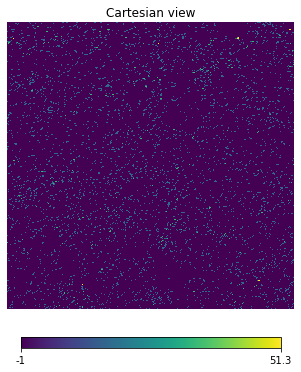

In [9]:
hp.cartview(CMASS_masked_dn, lonra=[100,110], latra=[50,60])

## Calculate the fraction of sky that is unmasked

In [10]:
# The "total" mask is product of PLANCK and CMASS masks
mask_tot = CMASS_mask * CIB_mask
fsky = np.sum(mask_tot) / len(mask_tot) # fsky for the cross-correlation
fsky_CIB = np.sum(CIB_mask) / len(CIB_mask)
fsky_CMASS = np.sum(CMASS_mask) / len(CMASS_mask)
print("f_sky cross = " + str(fsky))
print("f_sky CIB = " + str(fsky_CIB))
print("f_sky CMASS = " + str(fsky_CMASS))

f_sky cross = 0.23778559348003614
f_sky CIB = 0.5787552197774252
f_sky CMASS = 0.24298095703125


## Cross correlation

In [11]:
Cl_cross = hp.anafast(CIB_masked, map2 = CMASS_masked_dn, lmax = 1500)
ls = np.arange(len(Cl_cross))
pixwinf = hp.pixwin(N_side)[0:len(Cl_cross)]
# further divide by one power of beam
Cl_cross = Cl_cross / (pixwinf **2)                # Remove pixel window function
Cl_cross = Cl_cross / fsky                         # Undo the dilution caused by having observed only part of the sky

## Auto correlations -- needed for the error

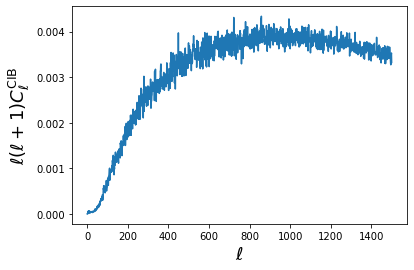

In [12]:
# Same as before!
Cl_CIB = hp.anafast(CIB_masked, lmax = 1500)
Cl_CMASS = hp.anafast(CMASS_masked_dn, lmax = 1500)
Cl_CIB = Cl_CIB / (pixwinf **2)
Cl_CMASS = Cl_CMASS / (pixwinf **2)
Cl_CIB = Cl_CIB / fsky_CIB
Cl_CMASS = Cl_CMASS / fsky_CMASS

# Let's see what the CIB power spectrum looks like.  Note that it looks "noisy" because it's not yet binned! 
# Note that the normalization here is not quite right, since I am dividing by the f_sky of the overlap with galaxies,
# not the f_sky of the CIB map.  
pl.xlabel(r'$\ell$', fontsize = 18)
pl.ylabel(r'$\ell (\ell+1) C_{\ell}^{\rm CIB}$', fontsize = 18)
pl.plot(ls, ls*(ls+1)* Cl_CIB)
pl.show()

## Binning

In [13]:
# Number of bins and range
Nbins = 5
lmin = 30
lmax = 1400

bins = np.round(np.linspace(lmin, lmax, Nbins+1))   # Bin edges
bins = bins.astype(int)
lcenterbin = np.zeros(len(bins)-1)
binned_cross = np.zeros(len(bins)-1)
binned_CIB = np.zeros(len(bins)-1)
binned_CMASS = np.zeros(len(bins)-1)

for k in range(0, len(bins)-1):  
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    lcenterbin[k] = np.round(0.5 * (bins[k] + bins[k+1]))   # bin center
    for l in lmaxvec:
        binned_cross[k] += Cl_cross[l]
    binned_cross[k] = binned_cross[k] / len(lmaxvec)

for k in range(0, len(bins)-1): 
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    for l in lmaxvec:
        binned_CIB[k] += Cl_CIB[l]
    binned_CIB[k] = binned_CIB[k] / len(lmaxvec)

for k in range(0, len(bins)-1): 
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    for l in lmaxvec:
        binned_CMASS[k] += Cl_CMASS[l]
    binned_CMASS[k] = binned_CMASS[k] / len(lmaxvec)

## Computing theory errors on the cross-correlation

__NOTE:__ The $C_\ell$ here are the "empirical" power spectra, i.e. they include noise.  For convenience here we use the measured ones. It would be better to have a "smooth" fiducial model that fits the data.

In [14]:
sigmavecth = np.zeros(len(bins)-1)
for k in range(0, len(bins)-1):
    lmaxvec = np.arange(bins[k], bins[k+1], 1)
    for l in lmaxvec:
        sigmavecth[k] += fsky * (2. * l + 1.) / (Cl_CIB[l] * Cl_CMASS[l] + Cl_cross[l]**2)
    sigmavecth[k] = 1. / sigmavecth[k]
sigmavecth = np.sqrt(sigmavecth)

## Plotting the cross-correlation

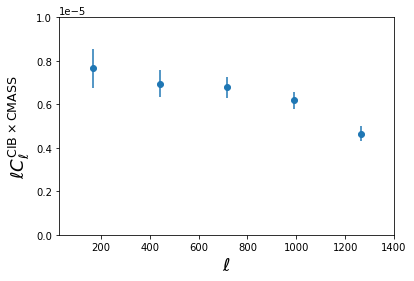

In [15]:
pl.errorbar(lcenterbin, lcenterbin * binned_cross, yerr = lcenterbin * sigmavecth, fmt = 'o', label = 'Data')
pl.xlabel(r'$\ell$', fontsize = 18)
pl.ylabel(r'$\ell C_{\ell}^{{\rm CIB} \times {\rm CMASS}}$', fontsize = 18)
pl.axhline(y = 0 , color = 'k', lw = 0.5)
pl.xlim([lmin, lmax])
pl.ylim([0,1e-5])
pl.show()

# Fitting a theory curve to the data

Now that we have our measurements, the next step is to find the theoretical model that best fits the observed data. Typically, models are built around a physical understanding of the process we would like to study (e.g., star-formation in galaxies). The idea is to capture the behaviour via a set of equations --- the simpler these are, the better --- featuring some constants/parameters whose value it is our job to determine by comparing to observations.  In our case, we will take a model for the Cl's proposed by experts on star-fromation, and find the model parameters that best fit our measured Cls. This is, in a nutshell, how we extract physical insights from observations.

### A toy model

Before we fit an actual theory-inspired model, let's get our feet wet by fitting a simple curve to our data points (this will be useful MUCH more generally). For this, we will use the function curve_fit() in scipy. You can see more details on this function at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [16]:
from scipy.optimize import curve_fit

Let's fit a power law of the form $f(l) = c\,  l^m +c_0$. 

In [17]:
def func_powerlaw(l, m, c, c0):
    return c0 + l**m * c

X = lcenterbin
Y = binned_cross
sigma_Y = sigmavecth
func_to_be_fit = func_powerlaw

# It is a good idea to provide an initial guess for the values of the parameters m,c and c0 to help curve_fit converge
intial_guess = np.asarray([6e-8,-1,0])

# We call curve_fit. Note that we provide our estimate uncertainty on each data point (sigma_Y). This helps
# curve_fit weight more strongly the points we have greater confidence in
popt, pcov = curve_fit(func_to_be_fit, X, Y, p0=intial_guess , sigma=sigma_Y)

Curve_fit has returned the parameter values with which the power law best fits the data (popt) as well as the covariance of these parameters (pcov). The covariance is an NxN matrix which essentially tells us the uncertainty on the values of our N parameters: the diagonal entries give us the variance, and the square root of the variance is the standard deviation. For example:

In [18]:
print(popt[0])
print(np.sqrt(pcov[0,0]))

6.583277580811102e-08
6.986094015904495e-09


So $m=3.2\times 10^{-8} \pm 0.2 \times 10^{-8}$, and similarly for the other two parameters

Let's take a look at how well our model fits the data:

On a log-linear plot


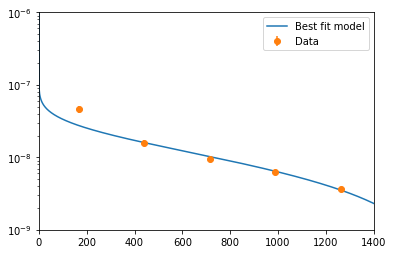

On a linear plot


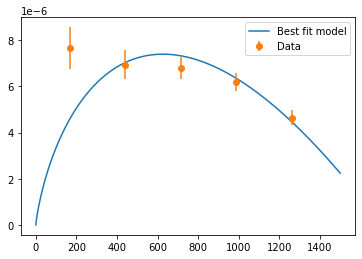

In [19]:
# Evaluate the power law function with the best-fit parameters and plot the result
pl.plot(ls, func_to_be_fit(ls, *popt), label=r'Best fit model')

# Plot also the data points
pl.errorbar(X, Y, yerr =sigma_Y, fmt = 'o', label = 'Data')

print('On a log-linear plot')
pl.yscale('log')

pl.xlim([0, lmax])
pl.ylim([1e-9,1e-6])
pl.legend()
pl.show()



print('On a linear plot')

pl.plot(ls, ls*func_to_be_fit(ls, *popt), label=r'Best fit model')
pl.errorbar(X, X* Y, yerr = X*sigma_Y, fmt = 'o', label = 'Data')
pl.yscale('linear')
pl.legend()


Admittedly, this model is not very good! There are quantitative measures of goodness of fit that you should feel free to look up (e.g., the reduced-chi-squared), but we won't discuss them for now. You can play around and see if you can find another function that better fits the data. But going forward, we will want to use functional forms that are motivated by theory and use parameters that have a clear connection with the physics we would like to investigate.

In general, more complex models with more free parameters (in our case, we have three parameters:  m, c and c0) will give us better fits to the data. But this is rarely desirable: we risk "over-fitting", or being misled by statistical fluctuations of the data that don't tell us anything fundamental about the system. The simpler the model, the better, as long as it fits the data well enough.